# Filling Missing Values

The purpose of this notebook is to demonstrate and compare different techniques for filling missing values in a dataset.

From `config.yaml`:
```
  temporal_fill:
    target_columns:
      - soil_moisture_5cm
      - soil_moisture_10cm
      - soil_moisture_20cm
      - soil_moisture_50cm
      - soil_moisture_100cm
      - air_temp_mean
      - rh_mean
      - solar_radiation
      - sur_temp_avg
    max_gap_days: 5
    switch_gap: 4
    regression_window: 7
```

Comparing 4 approaches:
1. Linear Interpolation
2. Forward Fill / Backward Fill
3. Regression-based Fill
4. XGBoost-based Fill

In [36]:
import sys
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt

project_root = Path.cwd().parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from pipes.request_pipe import RequestPipe
from pipes.parse_pipe import ParsePipe

In [7]:
TARGETS = ["soil_moisture_5cm", "soil_moisture_10cm", "soil_moisture_20cm",
           "soil_moisture_50cm", "soil_moisture_100cm", "air_temp_mean",
           "rh_mean", "solar_radiation", "sur_temp_avg"]

MAX_GAP_DAYS = 5
SWITCH_GAP = 4
REGRESSION_WINDOW = 7

In [8]:
req = RequestPipe()
parser = ParsePipe()
df = parser.run(req.run())

df = df.sort_values(["station_id", "date"])
station_id = df["station_id"].iloc[0]

data = df[df["station_id"] == station_id].copy()
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")

In [9]:
df.head()

,station_id,date,crx_vn,longitude,latitude,air_temp_max,air_temp_min,air_temp_mean,air_temp_avg,precipitation,...,soil_moisture_10cm,soil_moisture_20cm,soil_moisture_50cm,soil_moisture_100cm,soil_temp_5cm,soil_temp_10cm,soil_temp_20cm,soil_temp_50cm,soil_temp_100cm,source_file
0,4136,2007-07-31,1.302,-117.53,47.42,<NA>,<NA>,<NA>,<NA>,<NA>,...,-99.0,-99.0,-99.0,-99.0,NaN,NaN,NaN,NaN,NaN,uscrn_WA_Spokane_17_SSW_2007.txt
1,4136,2007-08-01,1.302,-117.53,47.42,32.9,2.4,17.7,19.4,0.0,...,-99.0,-99.0,-99.0,-99.0,NaN,NaN,NaN,NaN,NaN,uscrn_WA_Spokane_17_SSW_2007.txt
2,4136,2007-08-02,1.302,-117.53,47.42,35.4,4.0,19.7,22.0,0.0,...,-99.0,-99.0,-99.0,-99.0,NaN,NaN,NaN,NaN,NaN,uscrn_WA_Spokane_17_SSW_2007.txt
3,4136,2007-08-03,1.302,-117.53,47.42,29.4,7.5,18.4,21.5,0.0,...,-99.0,-99.0,-99.0,-99.0,NaN,NaN,NaN,NaN,NaN,uscrn_WA_Spokane_17_SSW_2007.txt
4,4136,2007-08-04,1.302,-117.53,47.42,27.6,6.5,17.0,18.0,0.0,...,-99.0,-99.0,-99.0,-99.0,NaN,NaN,NaN,NaN,NaN,uscrn_WA_Spokane_17_SSW_2007.txt


## Candidates

First, we need to check if all of these target columns are good canididates for filling missing values. If all of them are `NULL` for a given station, we can't fill them with anything but `NULL`.

In [10]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values(["station_id", "date"])

In [11]:
station_id = df["station_id"].iloc[0]
data = df[df["station_id"] == station_id].set_index("date")

In [12]:
data = data.replace(-99.0, pd.NA)

In [13]:
candidates = [col for col in TARGETS if data[col].notna().sum() > 0]
print("Candidate columns for interpolation:")
print(candidates)

Candidate columns for interpolation:
['soil_moisture_5cm', 'soil_moisture_10cm', 'soil_moisture_20cm', 'soil_moisture_50cm', 'soil_moisture_100cm', 'air_temp_mean', 'rh_mean', 'solar_radiation', 'sur_temp_avg']


In [14]:
excluded = set(TARGETS) - set(candidates)
if excluded:
    print("\nExcluded (all null or invalid):", list(excluded))
else:
    print("\nAll target columns are valid candidates.")


All target columns are valid candidates.


Good! :)

## Setup

We're going to use a small subset of the data for demonstration purposes...this can be safely scaled up to the full dataset later (I think).

In [15]:
valid_counts = data[TARGETS].notna().sum(axis=1)
non_empty_dates = data.index[valid_counts > 0]

print("First valid record:", non_empty_dates.min())
print("Last valid record:", non_empty_dates.max())

First valid record: 2007-08-01 00:00:00
Last valid record: 2025-10-18 00:00:00


In [16]:
# From Jun 1st 2018 to Sep 30th 2018

subset = data.loc["2018-06-01":"2018-09-30", TARGETS].copy()
subset = subset.replace(-99.0, pd.NA)

# Randomly mask 10%...ish of existing values to simulate gaps (same pattern for all)
mask = subset.notna() & (pd.DataFrame(np.random.rand(*subset.shape), index=subset.index, columns=subset.columns) < 0.1)
subset_masked = subset.mask(mask)

df_linear = subset_masked.copy(deep=True)
df_fbfill = subset_masked.copy(deep=True)
df_reg = subset_masked.copy(deep=True)
df_xgb = subset_masked.copy(deep=True)

In [17]:
subset.head()

,soil_moisture_5cm,soil_moisture_10cm,soil_moisture_20cm,soil_moisture_50cm,soil_moisture_100cm,air_temp_mean,rh_mean,solar_radiation,sur_temp_avg
date,,,,,,,,,
2018-06-01,0.153,0.183,0.171,0.138,0.129,10.7,59.7,22.01,14.5
2018-06-02,0.146,0.178,0.166,0.134,0.125,12.6,58.3,28.27,18.0
2018-06-03,0.137,0.172,0.16,0.129,0.12,16.4,51.1,25.82,21.9
2018-06-04,0.129,0.165,0.154,0.125,0.117,12.7,49.0,22.44,16.7
2018-06-05,0.122,0.16,0.148,0.121,0.113,10.9,53.7,27.66,16.1


In [18]:
print((df_linear.isna() == df_fbfill.isna()).all().all())
print((df_fbfill.isna() == df_reg.isna()).all().all())
print((df_reg.isna() == df_xgb.isna()).all().all())

True
True
True


## Evaluation Strategy

Since we dropped some values artificially, we can use those dropped values to evaluate the performance of each filling method. We'll use RMSE, MAE and R^2 as our evaluation metrics.

In [19]:
class Stopwatch:
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.time()

    def stop(self):
        if self.start_time is None:
            raise RuntimeError("Stopwatch not started.")
        self.elapsed = time.time() - self.start_time
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def __str__(self):
        return f"{self.elapsed:.3f} seconds"

def evaluate_fill(true_df, filled_df, targets):
    metrics = {}
    for col in targets:
        mask = true_df[col].notna()
        y_true = true_df.loc[mask, col]
        y_pred = filled_df.loc[mask, col]

        valid_mask = y_pred.notna()
        y_true = y_true[valid_mask]
        y_pred = y_pred[valid_mask]

        if len(y_true) == 0:
            metrics[col] = {"RMSE": np.nan, "MAE": np.nan, "R2": np.nan}
            continue

        metrics[col] = {
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R2": r2_score(y_true, y_pred),
        }
    return pd.DataFrame(metrics).T

def physical_validity_check(df, targets):
    invalid = {}
    for col in targets:
        s = df[col]
        if "soil_moisture" in col:
            invalid[col] = ((s < 0) | (s > 1)).sum()
        elif "temp" in col:
            invalid[col] = ((s < -60) | (s > 60)).sum()
        elif "radiation" in col:
            invalid[col] = (s < 0).sum()
        elif "rh_mean" in col:
            invalid[col] = ((s < 0) | (s > 100)).sum()
        else:
            invalid[col] = 0
    return pd.DataFrame.from_dict(invalid, orient="index", columns=["Invalid Count"])

def summarize_results(results_dict):
    records = []
    for method, (metrics_df, runtime) in results_dict.items():
        df_tmp = metrics_df.copy()
        df_tmp["Runtime (s)"] = runtime
        df_tmp["Method"] = method
        records.append(df_tmp)
    summary = pd.concat(records)
    return summary.reset_index(names=["Target"])

This means we're perfectly aligned across all 4 dfs.

---
### Linear Interpolation

In [20]:
df_linear = df_linear.apply(pd.to_numeric, errors="coerce")

timer = Stopwatch()
timer.start()

linear_filled = df_linear.interpolate(method="linear", limit=MAX_GAP_DAYS)

runtime_linear = timer.stop()
print(f"Linear interpolation completed in {runtime_linear:.3f} seconds")

# Evaluate performance
linear_metrics = evaluate_fill(subset, linear_filled, TARGETS)
invalid_linear = physical_validity_check(linear_filled, TARGETS)

display(linear_metrics)
display(invalid_linear)

Linear interpolation completed in 0.002 seconds


,RMSE,MAE,R2
soil_moisture_5cm,0.001133,0.000204,0.998919
soil_moisture_10cm,0.000144,0.000025,0.999982
soil_moisture_20cm,0.000187,0.000047,0.999964
soil_moisture_50cm,0.000232,0.000058,0.999934
soil_moisture_100cm,0.000234,0.000063,0.999914
air_temp_mean,0.293298,0.073278,0.994720
rh_mean,2.961240,0.731543,0.892900
solar_radiation,2.042213,0.436405,0.868763
sur_temp_avg,0.602990,0.143939,0.987373


,Invalid Count
soil_moisture_5cm,0
soil_moisture_10cm,0
soil_moisture_20cm,0
soil_moisture_50cm,0
soil_moisture_100cm,0
air_temp_mean,0
rh_mean,0
solar_radiation,0
sur_temp_avg,0


---
### Forward Fill / Backward Fill

In [21]:
df_fbfill = df_fbfill.apply(pd.to_numeric, errors="coerce")

timer.reset()
timer.start()

fb_filled = (
    df_fbfill
    .ffill(limit=MAX_GAP_DAYS)
    .bfill(limit=MAX_GAP_DAYS)
)

runtime_fb = timer.stop()
print(f"Forward/Backward fill completed in {runtime_fb:.3f} seconds")

fb_metrics = evaluate_fill(subset, fb_filled, TARGETS)
invalid_fb = physical_validity_check(fb_filled, TARGETS)

display(fb_metrics)
display(invalid_fb)

Forward/Backward fill completed in 0.001 seconds


,RMSE,MAE,R2
soil_moisture_5cm,0.002126,0.000504,0.996190
soil_moisture_10cm,0.000315,0.000050,0.999915
soil_moisture_20cm,0.000436,0.000107,0.999802
soil_moisture_50cm,0.000375,0.000091,0.999827
soil_moisture_100cm,0.000766,0.000190,0.999073
air_temp_mean,0.630033,0.152893,0.975638
rh_mean,3.537403,0.842975,0.847168
solar_radiation,2.906263,0.586364,0.734220
sur_temp_avg,0.685324,0.182645,0.983689


,Invalid Count
soil_moisture_5cm,0
soil_moisture_10cm,0
soil_moisture_20cm,0
soil_moisture_50cm,0
soil_moisture_100cm,0
air_temp_mean,0
rh_mean,0
solar_radiation,0
sur_temp_avg,0


---
### Regression-based Fill

In [22]:
def rolling_regression_fill(df, targets, window=REGRESSION_WINDOW):
    df = df.copy()
    for col in targets:
        series = df[col].astype(float)
        for i in range(window, len(series)):
            if pd.isna(series.iloc[i]):

                y = series.iloc[i - window:i].dropna()
                if len(y) >= 2:
                    try:
                        x = np.arange(len(y))
                        coeffs = np.polyfit(x, y.values, deg=1)
                        series.iloc[i] = coeffs[1] + coeffs[0] * len(y)
                    except Exception as e:
                        print(f"[WARN] Regression failed for {col} at index {i}: {e}")
        df[col] = series
    return df

df_reg = df_reg.apply(pd.to_numeric, errors="coerce")

timer.reset()
timer.start()

reg_filled = rolling_regression_fill(df_reg, TARGETS, window=REGRESSION_WINDOW)

runtime_reg = timer.stop()
print(f"Regression-based fill completed in {runtime_reg:.3f} seconds")

reg_metrics = evaluate_fill(subset, reg_filled, TARGETS)
invalid_reg = physical_validity_check(reg_filled, TARGETS)

display(reg_metrics)
display(invalid_reg)


Regression-based fill completed in 0.021 seconds


,RMSE,MAE,R2
soil_moisture_5cm,0.001154,0.000284,0.998721
soil_moisture_10cm,0.000250,0.000057,0.999947
soil_moisture_20cm,0.000466,0.000113,0.999773
soil_moisture_50cm,0.000410,0.000104,0.999793
soil_moisture_100cm,0.000768,0.000181,0.999029
air_temp_mean,0.702757,0.158290,0.969689
rh_mean,3.851396,0.945484,0.820244
solar_radiation,2.910917,0.607831,0.731422
sur_temp_avg,0.963324,0.227867,0.968011


,Invalid Count
soil_moisture_5cm,0
soil_moisture_10cm,0
soil_moisture_20cm,0
soil_moisture_50cm,0
soil_moisture_100cm,0
air_temp_mean,0
rh_mean,0
solar_radiation,0
sur_temp_avg,0


---
### XGBoost-based Fill

In [32]:
from xgboost import XGBRegressor

# I fucked up somewhere up top, this is just to patch it on the spot...doesn't matter since this is not production level stuff
def add_lag_features(df, targets, lags=[1, 2, 3]):
    df = df.copy()
    for col in targets:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

def xgboost_fill(df, targets, window=REGRESSION_WINDOW):
    df = df.copy()
    df = df.apply(pd.to_numeric, errors="coerce")

    feature_cols = [
        c for c in df.columns
        if c not in targets
        and df[c].notna().sum() > 0
        and c != "station_id"
        and c != "source_file"
    ]
    if not feature_cols:
        print("[WARN] No valid feature columns found for XGBoost.")
        return df

    for col in targets:
        y = df[col]
        X = df[feature_cols]

        mask_train = y.notna()
        mask_pred = y.isna()

        if mask_train.sum() < 20:
            print(f"[WARN] Skipping {col} ... not enough non-null samples.")
            continue

        try:
            model = XGBRegressor(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )

            model.fit(X[mask_train], y[mask_train])

            if mask_pred.sum() > 0:
                preds = model.predict(X[mask_pred])
                df.loc[mask_pred, col] = preds

        except Exception as e:
            print(f"[ERROR] XGBoost failed for {col}: {e}")

    return df

df_xgb = add_lag_features(df_xgb, TARGETS, lags=[1, 2, 3])

timer.reset()
timer.start()

xgb_filled = xgboost_fill(df_xgb, TARGETS, window=REGRESSION_WINDOW)

runtime_xgb = timer.stop()
print(f"XGBoost-based fill completed in {runtime_xgb:.3f} seconds")

xgb_metrics = evaluate_fill(subset, xgb_filled, TARGETS)
invalid_xgb = physical_validity_check(xgb_filled, TARGETS)

display(xgb_metrics)
display(invalid_xgb)

XGBoost-based fill completed in 1.568 seconds


,RMSE,MAE,R2
soil_moisture_5cm,0.004325,0.000842,0.984238
soil_moisture_10cm,0.001267,0.000283,0.998627
soil_moisture_20cm,0.003730,0.000655,0.985470
soil_moisture_50cm,0.000880,0.000211,0.999047
soil_moisture_100cm,0.002028,0.000508,0.993502
air_temp_mean,0.553114,0.138197,0.981224
rh_mean,2.975361,0.722806,0.891876
solar_radiation,2.292547,0.524345,0.834618
sur_temp_avg,0.838270,0.184362,0.975596


,Invalid Count
soil_moisture_5cm,0
soil_moisture_10cm,0
soil_moisture_20cm,0
soil_moisture_50cm,0
soil_moisture_100cm,0
air_temp_mean,0
rh_mean,0
solar_radiation,0
sur_temp_avg,0


---
## Results

In [34]:
summary_metrics = pd.concat(
    [
        linear_metrics.assign(Method="Linear Interpolation"),
        fb_metrics.assign(Method="Forward/Backward Fill"),
        reg_metrics.assign(Method="Regression-based Fill"),
        xgb_metrics.assign(Method="XGBoost-based Fill"),
    ]
).set_index("Method")

summary_metrics = summary_metrics[["RMSE", "MAE", "R2"]]

print("\n=== Quantitative Evaluation Summary ===\n")
pd.options.display.float_format = "{:.4f}".format
display(summary_metrics.round(4))

invalid_summary = pd.DataFrame({
    "Linear": invalid_linear.sum(),
    "Ffill": invalid_fb.sum(),
    "Regression": invalid_reg.sum(),
    "XGBoost": invalid_xgb.sum(),
}).T

print("\n=== Physical Validity Check (Out-of-Range Counts) ===\n")
display(invalid_summary)


=== Quantitative Evaluation Summary ===



,RMSE,MAE,R2
Method,,,
Linear Interpolation,0.0011,0.0002,0.9989
Linear Interpolation,0.0001,0.0000,1.0000
Linear Interpolation,0.0002,0.0000,1.0000
Linear Interpolation,0.0002,0.0001,0.9999
Linear Interpolation,0.0002,0.0001,0.9999
Linear Interpolation,0.2933,0.0733,0.9947
Linear Interpolation,2.9612,0.7315,0.8929
Linear Interpolation,2.0422,0.4364,0.8688
Linear Interpolation,0.6030,0.1439,0.9874



=== Physical Validity Check (Out-of-Range Counts) ===



,Invalid Count
Linear,0
Ffill,0
Regression,0
XGBoost,0


## Plots

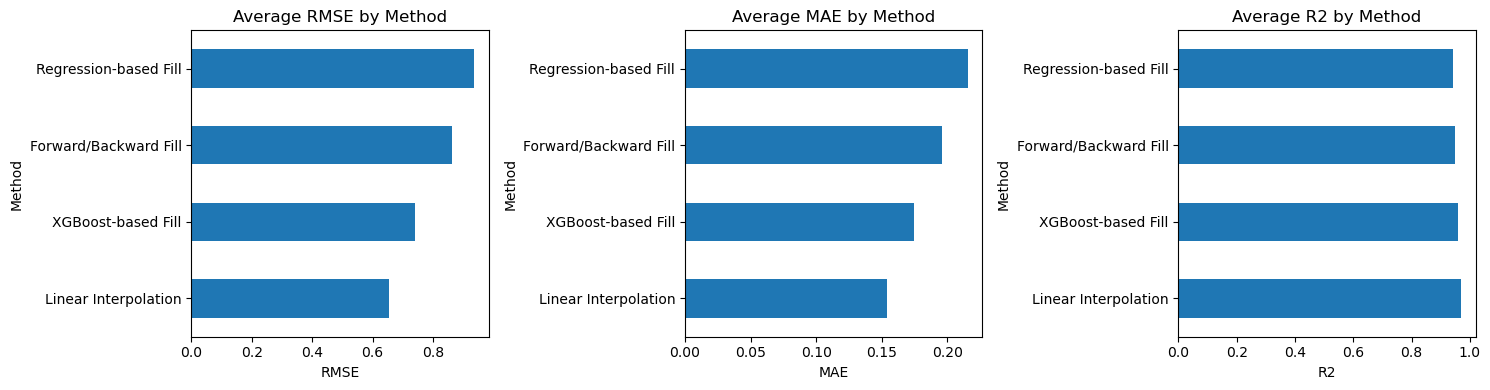

In [37]:
avg_scores = summary_metrics.groupby("Method")[["RMSE", "MAE", "R2"]].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, metric in enumerate(["RMSE", "MAE", "R2"]):
    avg_scores[metric].sort_values(ascending=(metric != "R2")).plot(
        kind="barh", ax=axes[i], title=f"Average {metric} by Method"
    )
    axes[i].set_xlabel(metric)
plt.tight_layout()
plt.show()

Lower RMSE/MAE is better, higher R^2 is better. Knowing that, we can clearly see that Linear Interpolation and XGBoost-based filling are the best methods overall, with Forward/Backward filling being a close third. Regression-based filling clearly the worst method here.

With that being said, I think our approach moving forward should be:

  use Linear Interpolation for small gaps (<= 2 days)
  use XGBoost-based filling for larger gaps (> 2 days)

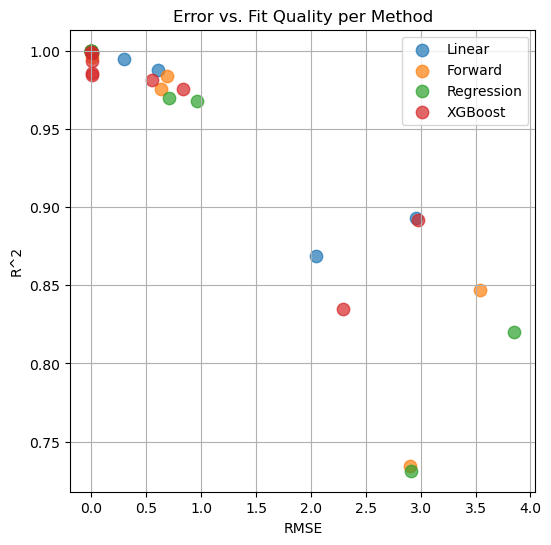

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))

for method, df_metrics in [
    ("Linear", linear_metrics),
    ("Forward", fb_metrics),
    ("Regression", reg_metrics),
    ("XGBoost", xgb_metrics),
]:
    ax.scatter(
        df_metrics["RMSE"], df_metrics["R2"],
        label=method, s=80, alpha=0.7
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("R^2")
ax.set_title("Error vs. Fit Quality per Method")
ax.legend()
plt.grid(True)
plt.show()

In [47]:
def rank_methods(df):
    means = df.groupby("Method")[["RMSE", "MAE", "R2"]].mean()
    ranks = means.rank(ascending={"RMSE": True, "MAE": True, "R2": False})
    ranks["Overall_Score"] = ranks.mean(axis=1)
    ranks = ranks.round(0).astype(int)

    return ranks.sort_values("Overall_Score")

ranked = rank_methods(summary_metrics)

print("\n=== Method Ranking (Lower = Better) ===\n")
display(ranked)


=== Method Ranking (Lower = Better) ===



,RMSE,MAE,R2,Overall_Score
Method,,,,
Linear Interpolation,1,1,4,2
XGBoost-based Fill,2,2,3,2
Forward/Backward Fill,3,3,2,3
Regression-based Fill,4,4,1,3
